This notebook contains code for illustrating the trade-off between bias and variance in high-dimensional regression.  We consider the regression model $y_i = \boldsymbol\beta^T\mathbf{x}_i + \varepsilon_i$ with $N = 100$ observations.  The true $\boldsymbol\beta = (2, 1, \underbrace{0, \ldots, 0}_{\textrm{p zeros}})$.  In other words, the first two covariates explain the outomce, but the rest are unrelated.  As $p$ grows, there are more and more noise variables in the model.  

We compare three regression methods in this setting:
1. OLS
2. LASSO
3. Adaptive LASSO

To do so, we draw data for the covariates 1,000 different times from $\mathbf{x}_i \sim \mathcal{N}(\mathbf{0}, \Sigma)$ where $\Sigma_{ii} = 1$ and $\Sigma_{ij} = \rho$ for $i \ne j$.  $y_i$ is then generated as a draw from $\mathcal{N}(\boldsymbol\beta^T\mathbf{x}_i, 1)$.  For each draw and each method, we record the value of $\widehat{\boldsymbol\beta}^T\mathbf{x}_0$, i.e. the predicted value of $y$ at $\mathbf{x}_0 = (2, \ldots, 2)$.  We can then compare the distribution of fitted values from each method to expected value of $y$ at $\mathbf{x}_0$, which is $6$, i.e. $\boldsymbol\beta^T\mathbf{x}_0$.

In [1]:
library(MASS)
library(glmnet)

dp <- function(x,y) return(sum(x * y))

rho <- 0.5  ## correlation between covariates
p <- 90  ## adjust this number to assess impact of increasing noise

beta <- c(2, 1, rep(0, p))  ## the true beta

mu <- rep(0, length(beta))

sigma <- diag(length(beta))  ## the variance-covariance matrix for the regressors
sigma[upper.tri(sigma)] <- rho
sigma[lower.tri(sigma)] <- rho

sims <- 1000  ## number of simulations

fitted_ols <- c()
fitted_lasso <- c()
fitted_alasso <- c()

x_0 <- rep(2, p+2)  
e_0 <- rnorm(sims)
f_0 <- dp(beta, x_0)
y_0 <- f_0 + e_0

x_1 <- c(1, x_0)
    
for(i in 1:sims){
    
    x <- mvrnorm(100, mu=mu, Sigma=sigma)
    y <- x %*% matrix(beta, ncol=1) + rnorm(nrow(x))
    
    mod <- lm(y ~ x)
    fitted_ols[i] <- dp(mod$coefficients, x_1)

    cvfit <- cv.glmnet(x, y)
    fitted_lasso[i] <- dp(coef(cvfit, s="lambda.1se"), x_1)

    weights <- 1 / abs(mod$coefficients[-1]) # adaptive LASSO weights
    cvfit <- cv.glmnet(x, y, penalty.factor=weights)
    fitted_alasso[i] <- dp(coef(cvfit, s="lambda.1se"), x_1)
    
}

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



First, we can illustrate the decomposition into variance and bias squared demonstrated in the lecture notes.  Note the total MSE will also include the variance of the irreducible error, which in this case is $1$.  The following codes do this for simple OLS, LASSO, and aLASSO, respectively.

In [2]:
cat("Bias Squared =", (mean(fitted_ols) - f_0)^2, "\n")
cat("Var Predictions =", var(fitted_ols), "\n")
cat("MSE =", mean((y_0 - fitted_ols)**2), "\n")

Bias Squared = 0.0007436127 
Var Predictions = 1.50311 
MSE = 2.463872 


In [3]:
cat("Bias Squared =", (mean(fitted_lasso) - f_0)^2, "\n")
cat("Var Predictions =", var(fitted_lasso), "\n")
cat("MSE =", mean((y_0 - fitted_lasso)**2), "\n")

Bias Squared = 0.8092873 
Var Predictions = 0.1417103 
MSE = 2.034993 


In [4]:
cat("Bias Squared =", (mean(fitted_alasso) - f_0)^2, "\n")
cat("Var Predictions =", var(fitted_alasso), "\n")
cat("MSE =", mean((y_0 - fitted_alasso)**2), "\n")

Bias Squared = 0.4188315 
Var Predictions = 0.1543397 
MSE = 1.629559 


For this specification of the simulation, both versions of LASSO outperform OLS due to substantially better variance even though both are biased.  Furthermore, the adaptive LASSO outperforms LASSO through reducing the bias.

Finally, we can plot the predicted values for $y$ to further compare the models.

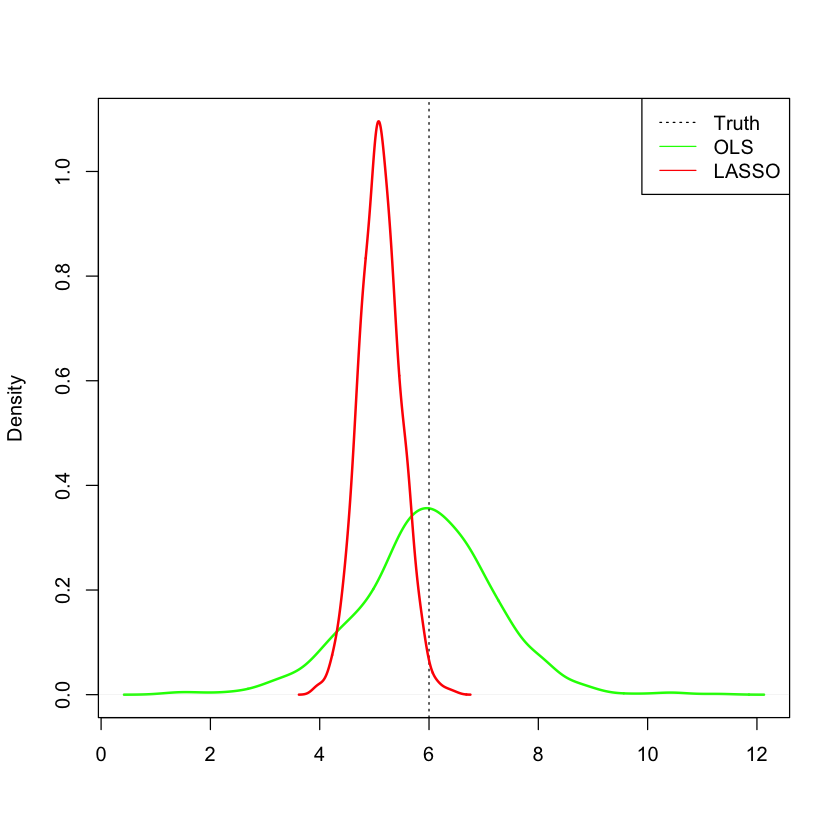

In [5]:
d_ols <- density(fitted_ols, bw="sj")
d_lasso <- density(fitted_lasso, bw="sj")

plot(d_ols,
     ylim=c(0, max(d_ols$y, d_lasso$y)),
     xlim=c(min(d_ols$x, d_lasso$x), max(d_ols$x, d_lasso$x)),
     col='green', lwd=2, xlab='', ylab='Density', main='')
abline(v=f_0, lty='dotted')
lines(d_lasso, col='red', lwd=2)
legend("topright",
       legend=c("Truth", "OLS", "LASSO"),
       col=c('black', 'green', 'red'),
       lty=c('dotted', 'solid', 'solid'))

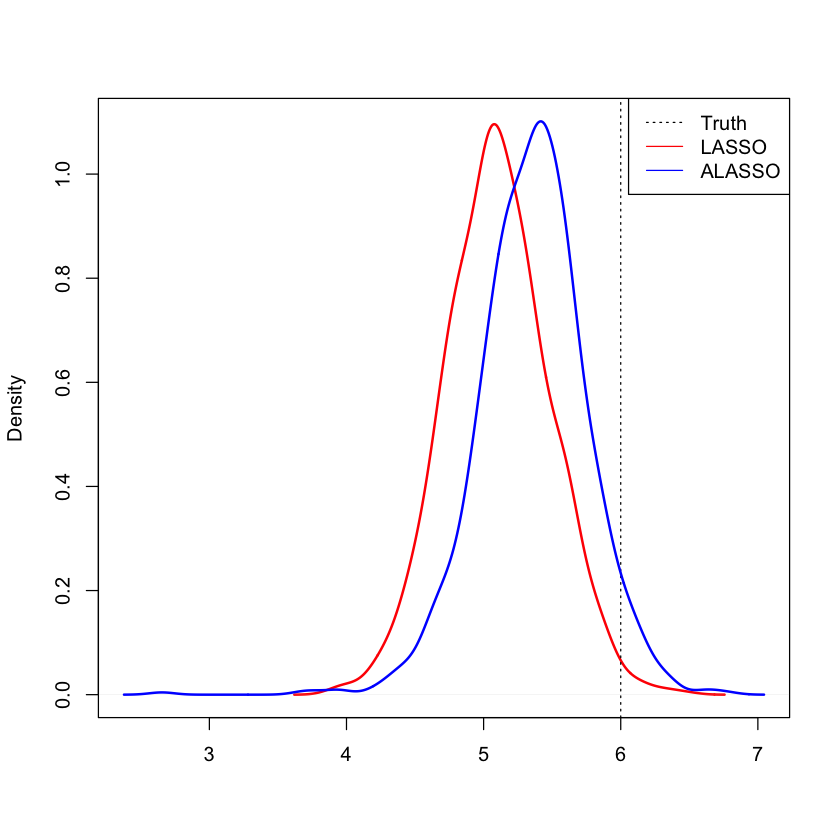

In [6]:
d_alasso <- density(fitted_alasso, bw="sj")

plot(d_lasso,
     ylim=c(0, max(d_lasso$y, d_alasso$y)),
     xlim=c(min(d_lasso$x, d_alasso$x), max(d_lasso$x, d_alasso$x)),
     col='red', lwd=2, xlab='', ylab='Density', main='')
abline(v=f_0, lty='dotted')
lines(d_alasso, col='blue', lwd=2)
legend("topright",
       legend=c("Truth", "LASSO", "ALASSO"),
       col=c('black', 'red', 'blue'),
       lty=c('dotted', 'solid', 'solid'))